# 1. Data wrangling and assembly pipeline

> download the data, run the viral genome assembly pipeline and sanity check the assemblies

***

## Overview

### 1. download the data

* viral reference genomes from RefSeq
* 3 Ebola virus (EBOV) MinIon run data
    - multiplexed on one flowcell
    - 3 strains of the virus (Mayinga, Kikwit, Makona) 
    - already basecalled with Guppy (both fast and high accuracy models)

### 2. run the pipeline

#### pipeline steps

* demux and trim basecalled reads with qcat
    * optional read subsampling with pomoxis
        * subsampled reads are used with all downstream Nanopolish processes
* **method 1**: align, variant call and augment the reference genome
    * assemble with minimap2
    * variant call with either:
        * **method 1.a**: medaka for variant calling
        * **method 1.b**: nanopolish for variant calling
    * augment the reference with each variant set using bcftools
* **method 2**: reference guided assembly
    * assemble with pomoxis (minimap2/miniasm/racon)
* **method 3**: de novo assembly
    * assemble with either miniasm or redbean
    * correct assemblies with racon
    * polish assemblies with either: 
        * **method 3.a**: medaka only
        * **method 3.b**: nanopolish only
        * **method 3.c**: medaka then nanopolish
        * **method 3.d**: nanopolish then medaka
* basic assessment of assemblies
    * quast
    * depth plots

#### pipeline output

The pipeline will produce several files per sample. It will place the files for each method in a sub directory in the specified output directory. This table summarises the method used to reach each:

| filename | method | summary |
| :---- | :---- | :---- |
| reference-alignment/barcode-XX.ref-alignment.medaka.fasta | method 1a | reference alignment > variant call with medaka > augment reference genome |
| reference-alignment/barcode-XX.ref-alignment.nanopolish.fasta | method 1b | reference alignment > variant call with nanopolish > augment reference genome |
| reference-guided-assembly/barcode-XX.rg-assembly.racon.fasta | method 2 | reference guided assembly > correct with racon |
| de-novo-assembly/barcode-XX.dn-assembly.racon.medaka.fasta | method 3a | de novo assembly > correct with racon > polish with medaka |
| de-novo-assembly/barcode-XX.dn-assembly.racon.nanopolish.fasta | method 3b | de novo assembly > correct with racon > polish with nanopolish |
| de-novo-assembly/barcode-XX.dn-assembly.racon.medaka.nanopolish.fasta | method 3c | de novo assembly > correct with racon > polish with medaka > polish with nanopolish |
| de-novo-assembly/barcode-XX.dn-assembly.racon.nanopolish.medaka.fasta | method 3d | de novo assembly > correct with racon > polish with nanopolish > polish with medaka |


### 3. assess the assemblies

* quick assessment of all the assemblies against the current viral genomes in RefSeq
* **note**: I've restricted this to just ebola for now, but can make this more generic later

***

## Download the data

Download the complete ebola assemblies from RefSeq:

In [1]:
!ncbi-genome-download --format fasta --assembly-level complete --fuzzy-genus --genus ebola viral -o tmp --parallel 8 --retries 2

Download the Ebola virus Nanopore run data from the [artic data releases](http://artic.network/protocol_validation_2019.html):

* we are using the Ebola virus (EBOV) minion run that sequenced 3 strains of the virus (Mayinga, Kikwit, Makona) using the metagenomic protocol with rapid PCR kit

In [1]:
!wget -q --directory-prefix=tmp/ http://artic.s3.climb.ac.uk/run-folders/EBOV_Metagenomics.tar.gz 
!tar -xf tmp/EBOV_Metagenomics.tar.gz -C tmp/ --strip-components=1

  HTTP/1.1 200 OK
  Server: nginx/1.14.0
  Date: Wed, 23 Oct 2019 11:05:39 GMT
  Content-Type: application/gzip
  Content-Length: 1070346070
  Connection: keep-alive
  Accept-Ranges: bytes
  Last-Modified: Tue, 03 Sep 2019 15:29:47 GMT
  ETag: "6e2449545dc6d1ac030505b880132e29-8"
  x-amz-meta-s3cmd-attrs: atime:1567522299/ctime:1567522360/gid:1000/gname:artic/md5:eb30cd588722793c39455ceb97898874/mode:33188/mtime:1567522310/uid:1000/uname:artic
  x-amz-request-id: tx000000000000000020a5c-005db03403-358ae6ba-s3-warwick


## Long read assembly pipeline

The library that we just downloaded contains 3 barcoded samples - we want barcodes 9, 10 and 11 (9=Mayinga,10=Kikwit,11=Makona)

This library was already basecalled with Guppy, both using the fast and high accuracy (hac) models. These are already in the current repository:

>./pipelines/data/ebov-metagenomics-reads

The nextflow pipeline will perform reference alignment and variant calling, as well as both de-novo and reference guided assemblies.

* **note**: this takes around 10 minutes using the settings below
* **note**: make sure you have docker installed and the daemon is running!

First, we need to provide a reference genome for each of the barcodes. The reference genomes are already available in the repo:

>./pipelines/data/ebov-reference-genomes

The barcodes and corresponding reference genomes are:

|barcode|strain|reference|
|-------|------|---------|
|09     |mayinga|NC_002549.fasta|
|10     |kikwit|JQ352763.fasta|
|11     |makona|KR781608.fasta|

### Mayinga

In [1]:
!nextflow run pipelines/long-read-assembly.nf \
    -profile docker \
    --cpus 8 \
    --mem 14GB \
    --fastqDir $PWD/pipelines/data/ebov-metagenomics-reads/guppy-r941-fast \
    --fast5Dir $PWD/tmp/fast5_pass \
    --barcode 9 \
    --refGenome $PWD/pipelines/data/ebov-reference-genomes/NC_002549.fasta \
    --output pipelines/data/pipeline-results/mayinga/r941_min_fast \
    --assembler miniasm \
    --subSamplingDepth 0 \
    --label fast

N E X T F L O W  ~  version 19.07.0
Launching `pipelines/long-read-assembly.nf` [modest_engelbart] - revision: 5c12503d12
-------------------------------------------------------
long read assembly pipeline v0.1
-------------------------------------------------------
Directory with fastq: /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-metagenomics-reads/guppy-r941-fast
Directory with fast5: /Users/willrowe/Desktop/signal-check/tmp/fast5_pass
Reference genome: /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-reference-genomes/NC_002549.fasta
File prepend label: fast
Barcode        : 9
Sequencing kit : Auto
Sampling depth : na
Racon iterat.  : 4
Medaka model   : r941_min_fast
Output dir     : pipelines/data/pipeline-results/mayinga/r941_min_fast
Working dir    : /Users/willrowe/Desktop/signal-check/work
Max. memory    : 14GB
Max. CPUs      : 8
Profile        : docker
Current home   : /Users/willrowe
Current user   : willrowe
Current path   : /Users/willrowe/Desktop/signa


executor >  local (9)
[8f/7de928] process > demuxingReads                 [100%] 1 of 1 ✔
[41/e1dee0] process > referenceAlignment            [100%] 1 of 1 ✔
[34/f64964] process > subsamplingReads              [100%] 1 of 1 ✔
[24/885e5d] process > nanopolishIndexing            [100%] 1 of 1 ✔
[38/b7a31d] process > variantcallWithMedaka         [100%] 1 of 1 ✔
[-        ] process > variantcallWithNanopolish     -
[64/d196de] process > assemblingReadsRG             [100%] 1 of 1 ✔
[96/ef28a6] process > assemblingReadsDN             [100%] 1 of 1 ✔
[d4/4c8497] process > correctingAssemblyWithRaconDN [100%] 1 of 1 ✔
[c2/62137b] process > polishingWithMedakaDN         [  0%] 0 of 1
[-        ] process > repolishingWithNanopolishDN   -
[-        ] process > polishingWithNanopolishDN     -
[-        ] process > repolishingWithMedakaDN       -
[-        ] process > assessAssemblies              -

executor >  local (10)
[8f/7de928] process > demuxingReads                 [100%] 1 of 1 ✔
[41/e

Run the pipeline again, this time using the high accuracy basecalled data:

* **note**: we change the medaka model and the pipeline run label

In [2]:
!nextflow run pipelines/long-read-assembly.nf \
    -profile docker \
    --cpus 8 \
    --mem 14GB \
    --fastqDir $PWD/pipelines/data/ebov-metagenomics-reads/guppy-r941-hac \
    --fast5Dir $PWD/tmp/fast5_pass \
    --barcode 9 \
    --refGenome $PWD/pipelines/data/ebov-reference-genomes/NC_002549.fasta \
    --output pipelines/data/pipeline-results/mayinga/r941_min_hac \
    --assembler miniasm \
    --subSamplingDepth 0 \
    --medakaModel r941_min_high \
    --label hac

N E X T F L O W  ~  version 19.07.0
Launching `pipelines/long-read-assembly.nf` [small_joliot] - revision: 5c12503d12
-------------------------------------------------------
long read assembly pipeline v0.1
-------------------------------------------------------
Directory with fastq: /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-metagenomics-reads/guppy-r941-hac
Directory with fast5: /Users/willrowe/Desktop/signal-check/tmp/fast5_pass
Reference genome: /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-reference-genomes/NC_002549.fasta
File prepend label: hac
Barcode        : 9
Sequencing kit : Auto
Sampling depth : na
Racon iterat.  : 4
Medaka model   : r941_min_high
Output dir     : pipelines/data/pipeline-results/mayinga/r941_min_hac
Working dir    : /Users/willrowe/Desktop/signal-check/work
Max. memory    : 14GB
Max. CPUs      : 8
Profile        : docker
Current home   : /Users/willrowe
Current user   : willrowe
Current path   : /Users/willrowe/Desktop/signal-check


executor >  local (9)
[88/1a2e39] process > demuxingReads                 [100%] 1 of 1 ✔
[f8/967b26] process > referenceAlignment            [100%] 1 of 1 ✔
[eb/2059d1] process > subsamplingReads              [100%] 1 of 1 ✔
[f6/12fd01] process > nanopolishIndexing            [100%] 1 of 1 ✔
[9f/e5ca90] process > variantcallWithMedaka         [100%] 1 of 1 ✔
[-        ] process > variantcallWithNanopolish     -
[49/0461cd] process > assemblingReadsRG             [100%] 1 of 1 ✔
[ca/be34eb] process > assemblingReadsDN             [100%] 1 of 1 ✔
[80/40f821] process > correctingAssemblyWithRaconDN [100%] 1 of 1 ✔
[47/225b5d] process > polishingWithMedakaDN         [  0%] 0 of 1
[-        ] process > repolishingWithNanopolishDN   -
[-        ] process > polishingWithNanopolishDN     -
[-        ] process > repolishingWithMedakaDN       -
[-        ] process > assessAssemblies              -

executor >  local (10)
[88/1a2e39] process > demuxingReads                 [100%] 1 of 1 ✔
[f8/9

## Quick assessment of the assemblies

As a sanity check, check the assemblies from each of the above pipelines against the viral RefSeq genomes:

**note**: this is just using the ebola refseqs for now

In [3]:
# get a file list of all the viral genomes we downloaded from refseq
!find $PWD/tmp/refseq/viral/GCF_00*/*.gz > tmp/ref-genomes.list

# add in the ebola references we have already
!find $PWD/pipelines/data/ebov-reference-genomes/*.fasta >> tmp/ref-genomes.list

# get a file list of all the assemblies we just made
!find $PWD/pipelines/data/pipeline-results/mayinga/r941_min_*/*-assembly/*assembly.*.fasta > tmp/mayinga-assembled-genomes.list

# run fastani to compute Average Nucleotide Identity
!fastani --rl tmp/ref-genomes.list --ql tmp/mayinga-assembled-genomes.list -o tmp/assemblies-fastani.tab --fragLen 100 --matrix

>>>>>>>>>>>>>>>>>>
Reference = [/Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000848505.1/GCF_000848505.1_ViralProj14703_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000854085.1/GCF_000854085.1_ViralProj15006_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000855585.1/GCF_000855585.1_ViralProj15012_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000888475.1/GCF_000888475.1_ViralProj51257_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_000889155.1/GCF_000889155.1_ViralProj51245_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/tmp/refseq/viral/GCF_003505815.1/GCF_003505815.1_ASM350581v1_genomic.fna.gz, /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-reference-genomes/JQ352763.fasta, /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-reference-genomes/KR781608.fasta, /Users/willrowe/Desktop/signal-check/pipelines/data/ebov-reference-genomes/NC_002549.fa

In [1]:
# plot the pairwise ANI scores as a heatmap
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
sequential_colors = sns.color_palette("RdPu", 10)

# convert triangular matrix to a regular one (https://github.com/marbl/Mash/issues/9#issuecomment-509837201)
def lower_triangle_to_full_matrix(filename):
    num_lines_in_file = sum(1 for line in open(filename))
    distances = []
    sample_names = []

    with open(filename) as f:
        next(f) # skip sample count line
        for line in f:
            elements = line.strip().split('\t')
            for i, e in enumerate(elements):
                if e == 'NA':
                    elements[i] = 0.0
            elements[0] = os.path.basename(elements[0])
            sample_names.append(elements[0])
            row = [float(e) for e in elements[1:]]
            row.extend([0.0] * (num_lines_in_file-1-len(row)))
            distances.append(row)
        np_array = np.asarray(distances)
        index_upper = np.triu_indices(num_lines_in_file-1)
        np_array[index_upper] = np_array.T[index_upper]
        return pd.DataFrame(np_array, columns=sample_names, index=sample_names)

mayingaAssemblies = lower_triangle_to_full_matrix('tmp/assemblies-fastani.tab.matrix')

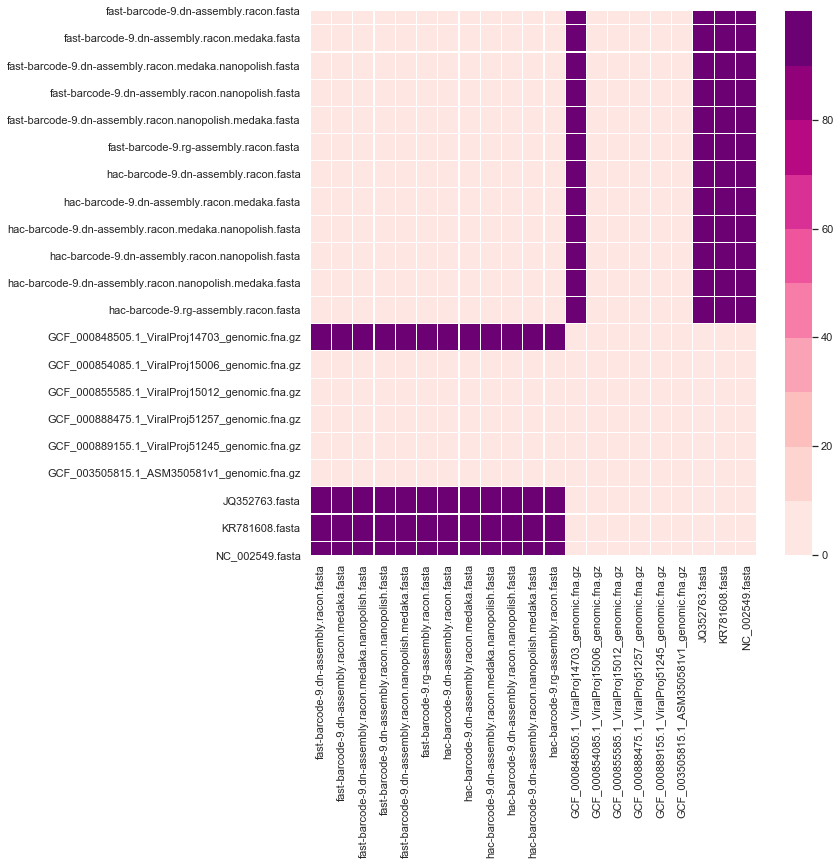

In [2]:
# make the plot
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(mayingaAssemblies, linewidths=.1, cmap=sequential_colors)

## Cleanup after running the pipeline

To free up space, move all the intermediary files. Make sure the `tmp` dir is kept as we use the contents in the next workbooks.

In [9]:
!rm -r work/
!rm -r .nextflow*

Move onto the [next workbook](2.evaluating-mayinga-assemblies.ipynb)